In [33]:
from pandas import DataFrame
from MyModule import Vocab, load_vocab, load_data

train_seg = load_data('train_segmented.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('val_segmented.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('test_segmented.txt', sep='<sp>', is_segmented=True)

train_idx = load_data('train_indexed.txt', sep=',', is_indexed=True)
val_idx = load_data('val_indexed.txt', sep=',', is_indexed=True)
test_idx = load_data('test_indexed.txt', sep=',', is_indexed=True)

vocab = load_vocab('vocab.txt')

### TF-IDF + 逻辑回归

In [34]:
# TF-IDF 特征化并构建 PyTorch Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame, Series


train_texts = [' '.join(tokens) for tokens in train_seg[0]]
val_texts = [' '.join(tokens) for tokens in val_seg[0]]
test_texts = [' '.join(tokens) for tokens in test_seg[0]]

train_labels = train_seg[1]
val_labels = val_seg[1]
test_labels = test_seg[1]

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

# 使用 PyTorch 实现的 Logistic Regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

e:\anaconda3\envs\nlpllma\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [35]:
from tqdm.auto import tqdm

num_class = 3
batch_size = 32
num_epoch = 5
input_dim = max_features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_tfidf = SparseTfidfDataset(X_train, train_seg[1])
test_dataset_tfidf = SparseTfidfDataset(X_test, test_seg[1])

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)

logreg.train()
for epoch in range(num_epoch):
    total_loss = 0
    for batch in tqdm(train_data_loader_tfidf, desc=f'Training Epoch {epoch+1}'):
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = logreg(inputs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_loss = total_loss / len(train_data_loader_tfidf)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')


acc = 0
for batch in tqdm(test_data_loader_tfidf, desc='Testing'):
    inputs, labels = batch

    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = logreg(inputs)
        preds = logits.argmax(dim=1)

        acc += (preds == labels).sum().item()
print(f'Test Accuracy: {acc / len(test_dataset_tfidf):.4f}')

Training Epoch 1:  30%|███       | 2363/7844 [00:26<01:00, 90.79it/s]



KeyboardInterrupt: 

### 多层感知机

In [36]:
# 通用训练、验证和测试框架
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
import torch

def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, 
                               num_epochs, device, target_names=['Negative', 'Neutral', 'Positive']):
    """
    通用的模型训练函数，支持验证集评估
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, LSTM, Transformer
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM with lengths
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    return history

def evaluate_model(model, data_loader, criterion, device):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_model_comprehensive(model, test_loader, device, target_names=['Negative', 'Neutral', 'Positive']):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(all_targets, all_preds, target_names)
    
    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

def plot_confusion_matrix(true_labels, pred_labels, target_names):
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(history, save_path=None):
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(range(1, num_epochs+1), history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(range(1, num_epochs+1), history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss & Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(range(1, num_epochs+1), acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title('Overfitting Monitor')
        plt.ylim(0, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_training_summary(history):
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")

In [37]:
# 融合词向量层的多层感知机
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F


class BowDataset(Dataset):
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]

def collate_fn_mlp(batch):
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b[0]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets

In [38]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class):
        super(MLP, self).__init__()
        # EmbeddingBag 层
        self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)

        # 词向量层：使用 EmbeddingBag
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)
        # self.dropout = nn.Dropout(dropout)
    
    def forward(self, inputs, offsets):
        # embeddings = self.embedding(inputs)  # (batch_size, seq_length, embed_size)
        # embedding = embeddings.mean(dim=1)  # (batch_size, embed_size)
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))  # (batch_size, hidden_size)
        outputs = self.linear2(hidden)  # (batch_size, output_size)

        # 获得每个序列属于某个类别概率的对数值
        # probs = F.log_softmax(outputs, dim=1)
        return outputs

In [39]:
# MLP 相关参数与数据加载
from tqdm.auto import tqdm

# 超参数设置
embedding_dim = 128
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 5

# 加载数据
train_dataset = BowDataset(train_idx)
val_dataset = BowDataset(val_idx)
test_dataset = BowDataset(test_idx)

train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

MLP(
  (embeddingbag): EmbeddingBag(33152, 128, mode='mean')
  (embedding): Embedding(33152, 128)
  (linear1): Linear(in_features=128, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
)

In [40]:
# MLP 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# 使用通用训练函数
history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:24<00:00, 287.84it/s]



Epoch 1/5
    Train Loss: 0.7118	Train Accuracy: 0.6948
    Valid Loss: 0.6354	Valid Accuracy: 0.7331
    Valid Precision: 0.7146	Valid Recall: 0.7331	Valid F1: 0.7136
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:23<00:00, 298.41it/s]



Epoch 2/5
    Train Loss: 0.5815	Train Accuracy: 0.7596
    Valid Loss: 0.6166	Valid Accuracy: 0.7436
    Valid Precision: 0.7284	Valid Recall: 0.7436	Valid F1: 0.7291
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:23<00:00, 302.11it/s]



Epoch 3/5
    Train Loss: 0.5288	Train Accuracy: 0.7828
    Valid Loss: 0.6147	Valid Accuracy: 0.7473
    Valid Precision: 0.7355	Valid Recall: 0.7473	Valid F1: 0.7385
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:23<00:00, 300.87it/s]



Epoch 4/5
    Train Loss: 0.4869	Train Accuracy: 0.8020
    Valid Loss: 0.6222	Valid Accuracy: 0.7460
    Valid Precision: 0.7367	Valid Recall: 0.7460	Valid F1: 0.7399
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:23<00:00, 299.37it/s]



Epoch 5/5
    Train Loss: 0.4460	Train Accuracy: 0.8210
    Valid Loss: 0.6441	Valid Accuracy: 0.7433
    Valid Precision: 0.7363	Valid Recall: 0.7433	Valid F1: 0.7388
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7536    0.8109    0.7812     17862
     Neutral     0.5014    0.4169    0.4553      8002
    Positive     0.8041    0.8038    0.8040     23165

    accuracy                         0.7433     49029
   macro avg     0.6864    0.6772    0.6802     49029
weighted avg     0.7363    0.7433    0.7388     49029



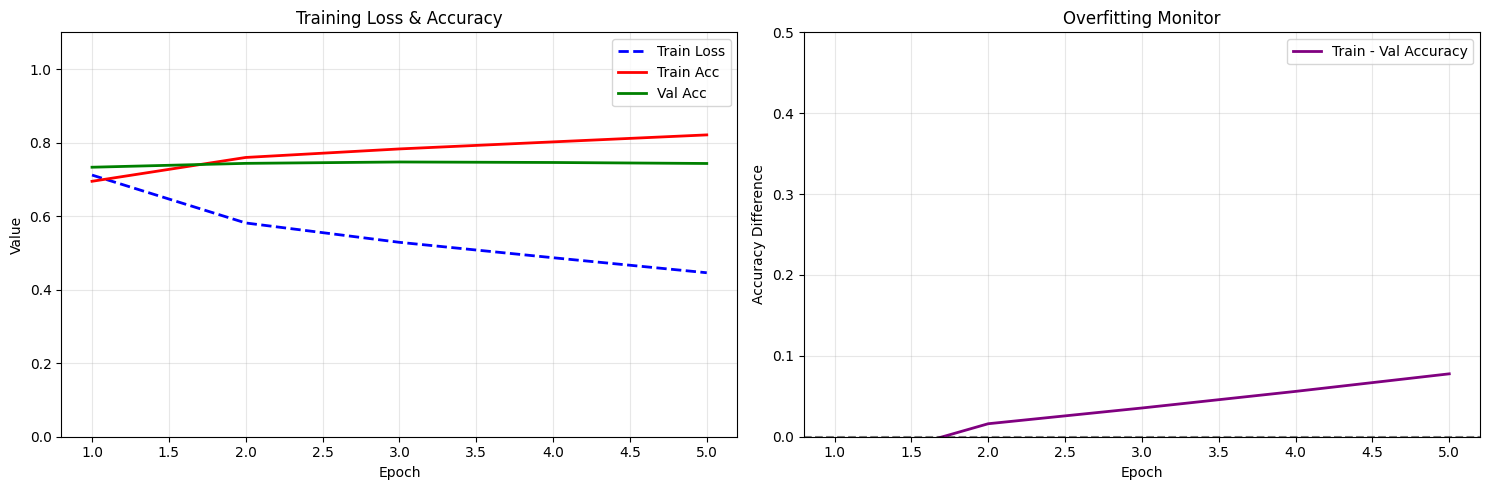


TRAINING SUMMARY
Final Train Loss: 0.4460
Final Train Accuracy: 0.8210
Final Val Loss: 0.6441
Final Val Accuracy: 0.7433
Best Val Accuracy: 0.7473 (Epoch 3)
Final Overfitting Gap: 0.0778


In [41]:
# 绘制训练曲线
plot_training_curves(history)

# 打印训练摘要
print_training_summary(history)

Testing: 100%|██████████| 49057/49057 [00:38<00:00, 1278.28it/s]




TEST RESULTS
Test Accuracy: 0.7425
Test Precision (weighted): 0.7358
Test Recall (weighted): 0.7425
Test F1 Score (weighted): 0.7382

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7546    0.8103    0.7815     17953
     Neutral     0.5033    0.4218    0.4590      8037
    Positive     0.8023    0.8014    0.8018     23067

    accuracy                         0.7425     49057
   macro avg     0.6867    0.6778    0.6808     49057
weighted avg     0.7358    0.7425    0.7382     49057



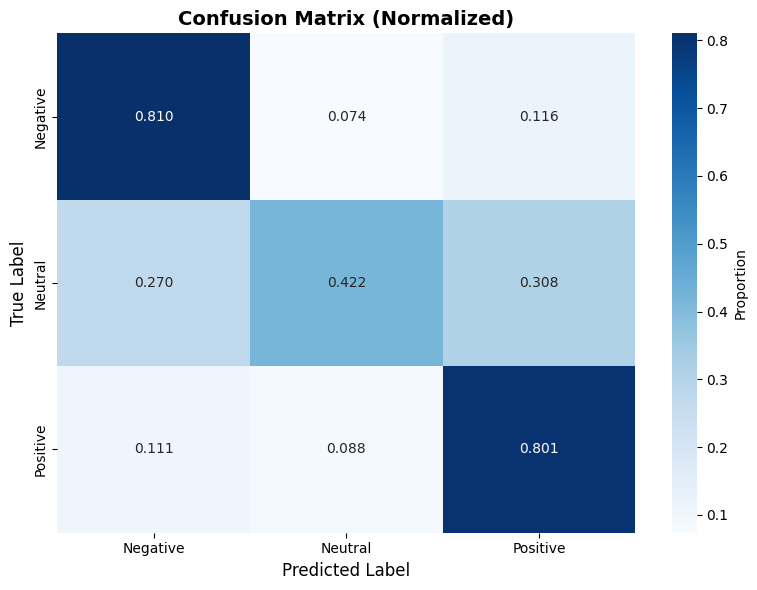


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7546, Recall=0.8103, F1=0.7815, Support=17953
 Neutral: Precision=0.5033, Recall=0.4218, F1=0.4590, Support=8037
Positive: Precision=0.8023, Recall=0.8014, F1=0.8018, Support=23067


In [42]:
# MLP 测试过程 - 使用通用框架
test_results = test_model_comprehensive(
    model=mlp,
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

### 卷积神经网络

In [43]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class) -> None:
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

In [44]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [45]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

CNN(
  (embedding): Embedding(33152, 128)
  (conv1d): Conv1d(128, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [46]:
# CNN 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)

# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:25<00:00, 276.08it/s]



Epoch 1/5
    Train Loss: 0.7091	Train Accuracy: 0.6923
    Valid Loss: 0.6311	Valid Accuracy: 0.7314
    Valid Precision: 0.7120	Valid Recall: 0.7314	Valid F1: 0.7112
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:25<00:00, 286.06it/s]



Epoch 2/5
    Train Loss: 0.5748	Train Accuracy: 0.7613
    Valid Loss: 0.6368	Valid Accuracy: 0.7443
    Valid Precision: 0.7316	Valid Recall: 0.7443	Valid F1: 0.7094
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:24<00:00, 288.56it/s]



Epoch 3/5
    Train Loss: 0.5026	Train Accuracy: 0.7948
    Valid Loss: 0.6199	Valid Accuracy: 0.7410
    Valid Precision: 0.7386	Valid Recall: 0.7410	Valid F1: 0.7367
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:24<00:00, 289.38it/s]



Epoch 4/5
    Train Loss: 0.4332	Train Accuracy: 0.8269
    Valid Loss: 0.6477	Valid Accuracy: 0.7394
    Valid Precision: 0.7461	Valid Recall: 0.7394	Valid F1: 0.7421
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:25<00:00, 284.10it/s]



Epoch 5/5
    Train Loss: 0.3634	Train Accuracy: 0.8585
    Valid Loss: 0.7021	Valid Accuracy: 0.7357
    Valid Precision: 0.7373	Valid Recall: 0.7357	Valid F1: 0.7365
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7766    0.7734    0.7750     17862
     Neutral     0.4523    0.4658    0.4589      8002
    Positive     0.8055    0.7998    0.8026     23165

    accuracy                         0.7357     49029
   macro avg     0.6781    0.6797    0.6789     49029
weighted avg     0.7373    0.7357    0.7365     49029



Testing: 100%|██████████| 49057/49057 [00:47<00:00, 1037.51it/s]




TEST RESULTS
Test Accuracy: 0.7317
Test Precision (weighted): 0.7221
Test Recall (weighted): 0.7317
Test F1 Score (weighted): 0.7258

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7494    0.7974    0.7726     17953
     Neutral     0.4644    0.3729    0.4137      8037
    Positive     0.7907    0.8056    0.7981     23067

    accuracy                         0.7317     49057
   macro avg     0.6682    0.6586    0.6615     49057
weighted avg     0.7221    0.7317    0.7258     49057



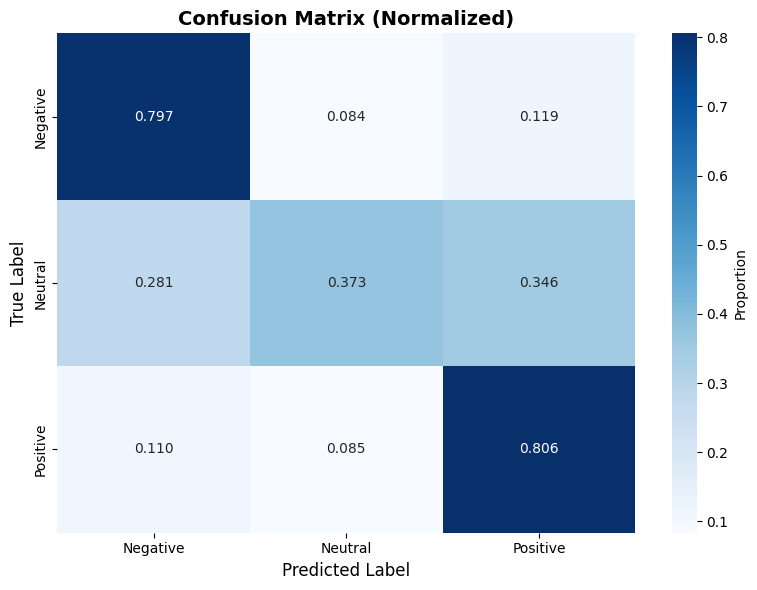


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7494, Recall=0.7974, F1=0.7726, Support=17953
 Neutral: Precision=0.4644, Recall=0.3729, F1=0.4137, Support=8037
Positive: Precision=0.7907, Recall=0.8056, F1=0.7981, Support=23067


In [47]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    test_loader=test_data_loader_cnn,
    device=device
)

### 长短时记忆网络

In [48]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):
    lengths = torch.tensor([len(b[0]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets

In [49]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class):
        super(LSTM, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        outputs = self.output(hn[-1])
        return outputs

In [50]:
train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

LSTM(
  (embeddings): Embedding(33152, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [51]:
# LSTM 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)

# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:36<00:00, 194.35it/s]



Epoch 1/5
    Train Loss: 0.6815	Train Accuracy: 0.7054
    Valid Loss: 0.6018	Valid Accuracy: 0.7441
    Valid Precision: 0.7255	Valid Recall: 0.7441	Valid F1: 0.7265
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:34<00:00, 208.07it/s]



Epoch 2/5
    Train Loss: 0.5267	Train Accuracy: 0.7805
    Valid Loss: 0.5777	Valid Accuracy: 0.7579
    Valid Precision: 0.7461	Valid Recall: 0.7579	Valid F1: 0.7498
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:33<00:00, 216.48it/s]



Epoch 3/5
    Train Loss: 0.4204	Train Accuracy: 0.8288
    Valid Loss: 0.6011	Valid Accuracy: 0.7568
    Valid Precision: 0.7494	Valid Recall: 0.7568	Valid F1: 0.7523
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:37<00:00, 188.51it/s]



Epoch 4/5
    Train Loss: 0.3074	Train Accuracy: 0.8801
    Valid Loss: 0.6783	Valid Accuracy: 0.7489
    Valid Precision: 0.7449	Valid Recall: 0.7489	Valid F1: 0.7468
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [01:01<00:00, 116.89it/s]



Epoch 5/5
    Train Loss: 0.2028	Train Accuracy: 0.9241
    Valid Loss: 0.8312	Valid Accuracy: 0.7384
    Valid Precision: 0.7414	Valid Recall: 0.7384	Valid F1: 0.7397
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7933    0.7683    0.7806     17862
     Neutral     0.4436    0.4673    0.4551      8002
    Positive     0.8042    0.8089    0.8065     23165

    accuracy                         0.7384     49029
   macro avg     0.6804    0.6815    0.6808     49029
weighted avg     0.7414    0.7384    0.7397     49029



Testing: 100%|██████████| 49057/49057 [01:18<00:00, 626.70it/s] 




TEST RESULTS
Test Accuracy: 0.7402
Test Precision (weighted): 0.7424
Test Recall (weighted): 0.7402
Test F1 Score (weighted): 0.7412

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7932    0.7710    0.7819     17953
     Neutral     0.4516    0.4700    0.4606      8037
    Positive     0.8042    0.8104    0.8073     23067

    accuracy                         0.7402     49057
   macro avg     0.6830    0.6838    0.6833     49057
weighted avg     0.7424    0.7402    0.7412     49057



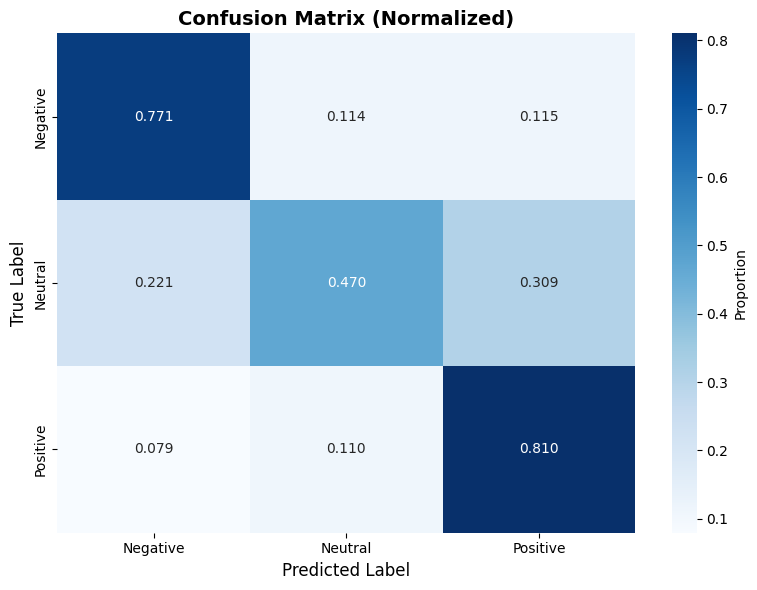


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7932, Recall=0.7710, F1=0.7819, Support=17953
 Neutral: Precision=0.4516, Recall=0.4700, F1=0.4606, Support=8037
Positive: Precision=0.8042, Recall=0.8104, F1=0.8073, Support=23067


In [52]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    test_loader=test_data_loader_lstm,
    device=device
)

### Transformer

In [53]:
def length_to_mask(lengths):
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

In [54]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [55]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, dim_feedforward=512, num_head=2, num_layers=2, dropout=0.1, max_len=128, activation: str = "relu"):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 去第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

In [56]:
collate_fn_trans = collate_fn_lstm

In [57]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, embedding_dim, num_class)
transformer.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(33152, 128)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=128, out_features=3, bias=True)
)

In [58]:
# Transformer 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)

# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7155/7155 [00:45<00:00, 156.97it/s]



Epoch 1/5
    Train Loss: 0.7771	Train Accuracy: 0.6617
    Valid Loss: 0.6980	Valid Accuracy: 0.7054
    Valid Precision: 0.6908	Valid Recall: 0.7054	Valid F1: 0.6779
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7155/7155 [00:47<00:00, 151.26it/s]



Epoch 2/5
    Train Loss: 0.6472	Train Accuracy: 0.7290
    Valid Loss: 0.6500	Valid Accuracy: 0.7291
    Valid Precision: 0.7137	Valid Recall: 0.7291	Valid F1: 0.7174
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7155/7155 [00:47<00:00, 152.14it/s]



Epoch 3/5
    Train Loss: 0.5890	Train Accuracy: 0.7570
    Valid Loss: 0.6349	Valid Accuracy: 0.7352
    Valid Precision: 0.7215	Valid Recall: 0.7352	Valid F1: 0.7215
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7155/7155 [00:47<00:00, 149.72it/s]



Epoch 4/5
    Train Loss: 0.5488	Train Accuracy: 0.7755
    Valid Loss: 0.6260	Valid Accuracy: 0.7403
    Valid Precision: 0.7282	Valid Recall: 0.7403	Valid F1: 0.7318
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7155/7155 [00:44<00:00, 160.73it/s]



Epoch 5/5
    Train Loss: 0.5170	Train Accuracy: 0.7906
    Valid Loss: 0.6372	Valid Accuracy: 0.7363
    Valid Precision: 0.7314	Valid Recall: 0.7363	Valid F1: 0.7333
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7554    0.8039    0.7789     17862
     Neutral     0.4721    0.4198    0.4444      8002
    Positive     0.8026    0.7935    0.7980     23165

    accuracy                         0.7363     49029
   macro avg     0.6767    0.6724    0.6738     49029
weighted avg     0.7314    0.7363    0.7333     49029



Testing: 100%|██████████| 49057/49057 [01:41<00:00, 485.12it/s]




TEST RESULTS
Test Accuracy: 0.7410
Test Precision (weighted): 0.7355
Test Recall (weighted): 0.7410
Test F1 Score (weighted): 0.7377

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7601    0.8101    0.7843     17953
     Neutral     0.4835    0.4230    0.4513      8037
    Positive     0.8042    0.7981    0.8011     23067

    accuracy                         0.7410     49057
   macro avg     0.6826    0.6771    0.6789     49057
weighted avg     0.7355    0.7410    0.7377     49057



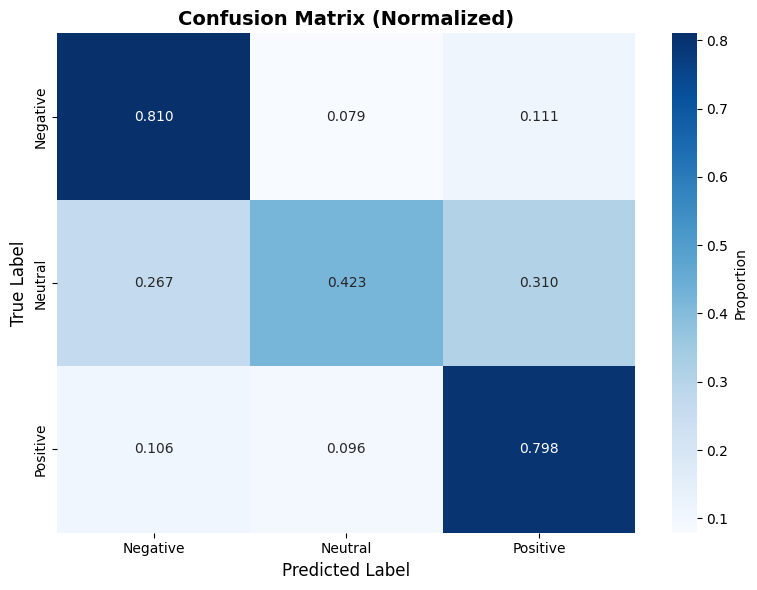


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7601, Recall=0.8101, F1=0.7843, Support=17953
 Neutral: Precision=0.4835, Recall=0.4230, F1=0.4513, Support=8037
Positive: Precision=0.8042, Recall=0.7981, F1=0.8011, Support=23067


In [59]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    test_loader=test_data_loader_trans,
    device=device
)


MODEL PERFORMANCE COMPARISON
      Model  Accuracy  Precision  Recall  F1 Score
        MLP    0.7425     0.7358  0.7425    0.7382
        CNN    0.7317     0.7221  0.7317    0.7258
       LSTM    0.7402     0.7424  0.7402    0.7412
Transformer    0.7410     0.7355  0.7410    0.7377


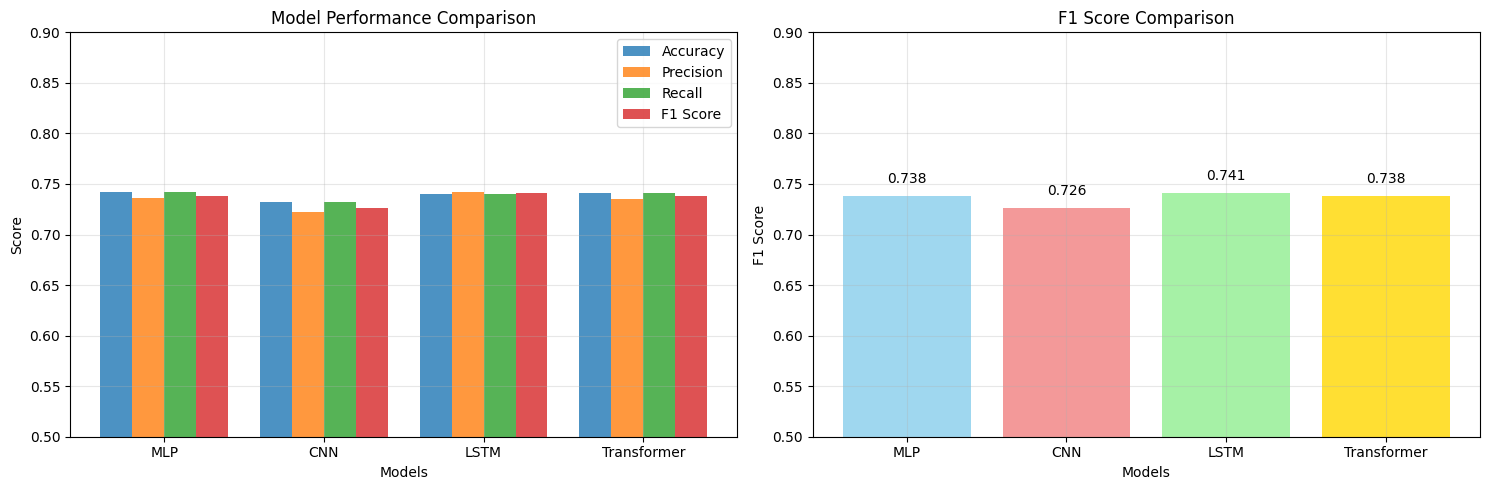


Best performing model: LSTM (F1 Score: 0.7412)


In [69]:
# 模型性能比较
def compare_models(model_results, model_names=None):
    """
    比较多个模型的性能
    
    Args:
        model_results: 模型结果字典的列表
        model_names: 模型名称列表
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_results))]
    
    # 创建比较表格
    import pandas as pd
    
    comparison_data = []
    for i, (name, result) in enumerate(zip(model_names, model_results)):
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1']
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.round(4).to_string(index=False))
    
    # 绘制比较图表
    plt.figure(figsize=(15, 5))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # 对应的字典键
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.subplot(1, 2, 1)
    for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
        values = [result[key] for result in model_results]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # F1分数单独比较
    plt.subplot(1, 2, 2)
    f1_scores = [result['f1'] for result in model_results]
    bars = plt.bar(model_names, f1_scores, alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # 在柱状图上显示数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳模型
    best_idx = np.argmax([result['f1'] for result in model_results])
    print(f"\nBest performing model: {model_names[best_idx]} (F1 Score: {model_results[best_idx]['f1']:.4f})")

# 使用示例（在所有模型都训练完成后运行）
model_results = [
    test_results,  # MLP
    cnn_test_results,  # CNN  
    lstm_test_results,  # LSTM
    transformer_test_results  # Transformer
]
model_names = ['MLP', 'CNN', 'LSTM', 'Transformer']
compare_models(model_results, model_names)